# AdventureWorks Försäljninganalys
I denna analys ska vi undersöka databasen AdventureWorks2025 för att besvara frågorna såsom:
- Antal produkter per kategori
- Försäljning per produktkategori
- Försäljning över tid 
- Försäljning och antal ordrar per år
- Top 10 produkter
- Försäljning och antal kunder per region 
- Genomsnittligt ordervärde per region och kundtyp 

Vi använder SQL för att hämta data och python för att visualisera analysen.




In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Jasiek2005")
server = 'localhost,1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\janek\AppData\Local\Temp\ipykernel_23356\1452838393.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str): 
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)


## Visualisering 1: Antal produkter per kategori 
Affärsfråga: Hur många produkter finns i varje kategori?

Tabbeler jag ska använda mig av: 
 Production.ProductCategory, Production.ProductSubcategory, Production.Product

 Plan: 

 - Gör en JOIN på tabellerna

 - Räkna DISTINCT produkter per kategori

 - Skapa en vertikal stapeldiagram(bar) med DESC ordning 
 
 - Analysera resultatet


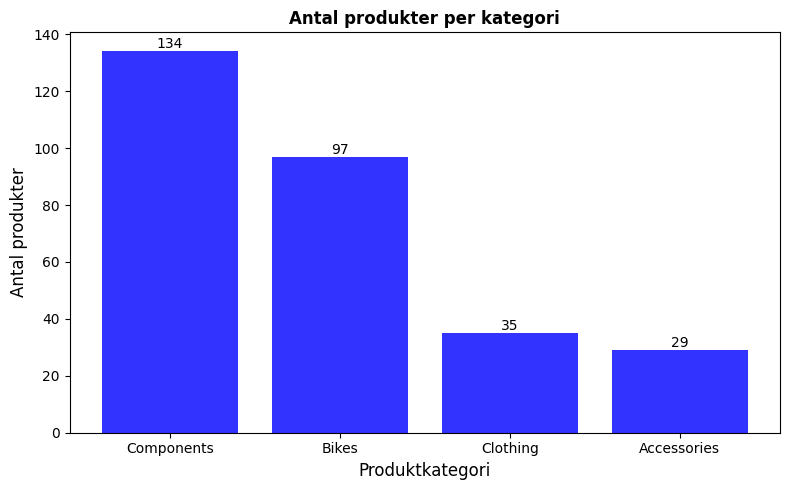

In [3]:
query_vis1 = """ 
SELECT
    pc.Name AS CategoryName, 
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc   
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name 
ORDER BY ProductCount DESC

"""

df_vis1= query_df(query_vis1)

fig,ax = plt.subplots(figsize=(8,5))
bars= ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='blue', alpha=0.8)

for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() /2,
            height,
            f'{int(height)}',
            ha ='center',
            va = 'bottom'
        )

ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Antal produkter", fontsize=12)
ax.set_title("Antal produkter per kategori" ,fontsize=12, fontweight= 'bold')
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori

Components är den största kategorin med 134 produkter 

Accesories är den minsta kategorin med bara 29 produkter i sin kategori

Detta indikerar att företagets största fokus ligger på komponenter som är nästan hälften av hela försäljningen och att 
Accesories och Clothing kan vara ett utvecklingsområde



## Visualisering 2: Försäljning per produktkategori
Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Tabeller jag ska använda mig av: 
Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

Plan:
- Göra en join på tabellerna
- Sortera från högst till lägst försäljning
- Skapa en horisontell stapeldiagram(barh)
- Sortera staplar DESC 
- Insikter - förklara vilken kategori som är störst och minst, med exakta siffror
    


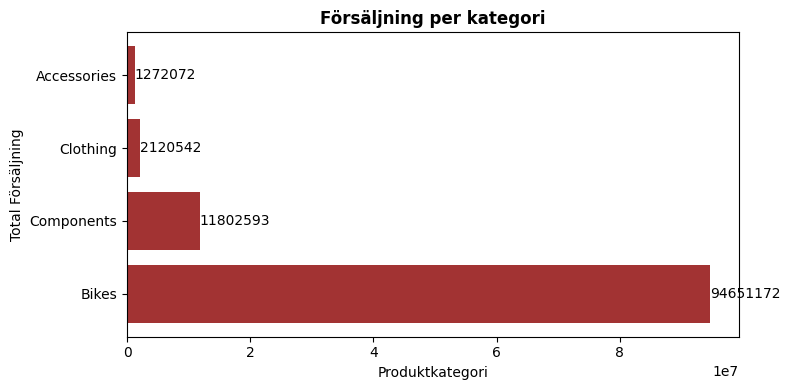

In [ ]:
query_vis2 = """  
SELECT 
    pc.Name AS ProduktKategori,
    ROUND(SUM(sod.LineTotal), 2) AS TotalFörsäjning
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p  ON p.ProductID = sod.ProductID 
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubCategoryID = psc.ProductSubCategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY SUM(sod.LineTotal) DESC

"""
df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(8,4))
bars = ax.barh(df_vis2['ProduktKategori'], df_vis2['TotalFörsäjning'], color = 'darkred', alpha=0.8)
for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() /2,
            f'{int(width)}',
            va ='center',
            ha = 'left'
        )
ax.set_title("Total Försäljning per produktkategori", fontweight="bold", fontsize=12)
ax.set_xlabel("Produktkategori", fontsize=10)
ax.set_ylabel("Total Försäljning", fontsize=10)
plt.tight_layout()
plt.show()



### Insikter - Försäljning per kategori
Försäljningen domineras tydligt av Bikes-kategorin med 94651172 total försäljing som står för majoriteten av intäkterna. Den minsta försäljningen har Accesories-kategorin med bara 1272072 total försäljning. 

Detta indikerar ett starkt beroende av cykelförsäljningen, samt stor obalans i intäktfördelningen. Components-kategorin har potential för tillväxt i framtiden. 

## Visualisering 3: Försäljningstrend över tid
Affärsfråga: Hur har försäljningen utvecklats över tid?

Tabeller jag ska använda mig av:
Sales.SalesOrderHeader

Plan:
- Joina tabeller
- Aggregera per månad(minst 12 månader data)
- Sortera kronologiskt(äldst först)
- Skapa en linjediagram(line plot)
- Visa tydlig tisdlinje på x-axeln
- Insikter - Beskriv trenden(ökning/minskning/säsongberoende), Nämn högsta och minsta månaden


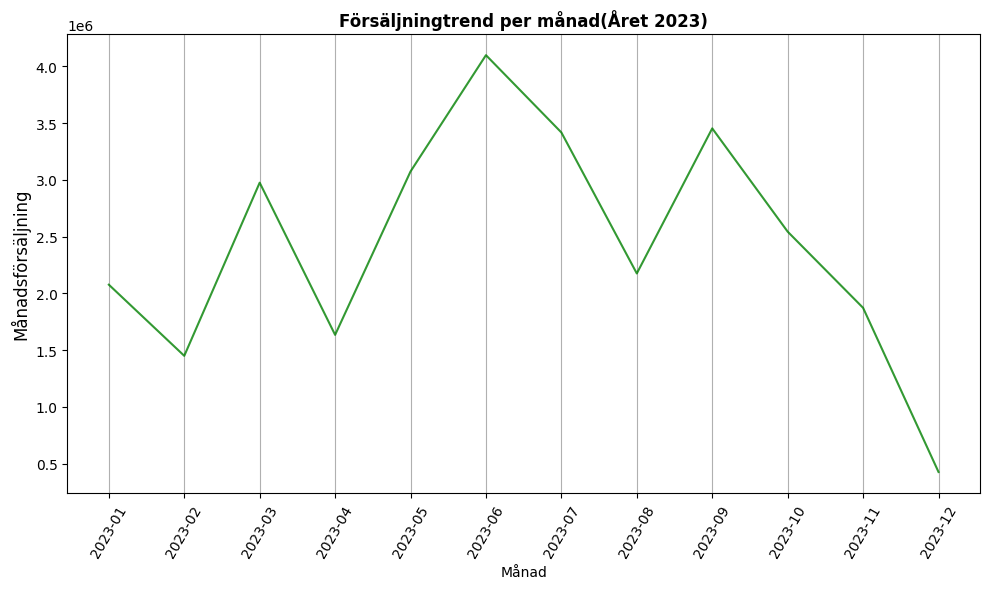

In [33]:
query_vis3 = """  
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS Månad,
    ROUND(SUM(SubTotal),2) AS Månadsförsäljning

FROM Sales.SalesOrderHeader 
WHERE OrderDate >= '2023-01-01' AND OrderDate < '2023-12-31'
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad ASC;

"""
df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_vis3['Månad'], df_vis3['Månadsförsäljning'], color = 'green', alpha=0.8)
ax.set_title("Försäljningtrend per månad(Året 2023)",fontweight= 'bold', fontsize=12)
ax.set_xlabel("Månad", fontsize=10)
ax.set_ylabel("Månadsförsäljning", fontsize=12)
ax.grid(axis='x')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### Insikter - Försäljningtrend över tid
Den lägsta försäljningen är i December och den högsta Juni.

Mellan April och Juni kan man se en kraftig ökning, vilket indikerar en stark efterfrågan under vårtiden. Man ser också en kraftig minskning mellan September som pågår till slutet av året som visar minskad efterfrågan under vintern.
